**Виконав:**

Студент ОІ-41: ***Мацишин Михайло***

Прийняв асистент, док.  філософії: ***Петро Лящинський***

# **Варіант 2**
*Продовження текстової послідовності (наприклад, cat sat -> on the mat).*

### **Дані**
• Використати будь-який текстовий датасет на вибір.

### **Реалізація**

•	Токенізація: простий split або стандартний BPE токенайзер HuggingFace.

•	Архітектура моделі: Embedding + позиційне кодування + 1-5 шарів TransformerDecoderLayer + Linear.

•	Метрика: Perplexity, BLEU, ROUGE-L.

•	Збереження моделі у файл.

•	Тюнінг гіперпараметрів (nhead, d_model).


##**Встановлення бібліотек**

In [3]:
!pip install evaluate[all] rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=fd0f80ff67c1fc3a358155e698cd737d048e5c87e1a75e8c6ab05f22811f9664
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [4]:
import math, random
from typing import List, Tuple
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

## **Конфігурація**

In [5]:
# ----------------------- Config -----------------------
SEED = 42
random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_TOKENS = 48
BATCH_SIZE = 32
EPOCHS_TUNE = 6
LR_BASE = 2e-3

## **Завантаження та аналіз датасету**

In [7]:
df = pd.read_csv('news_data.csv')

In [8]:
df.head(10).style

,Unnamed: 0,Text,Label
0,0,В Україні запустять механізм перевірки наявності подвійного або множинного громадянства. Особливо це стосуватиметься чиновників та депутатів. https://bit.ly/2P4NL8v,True
1,1,"У Флориді через рекордно низькі температури найбільше страждають тварини. Днями синоптики попередили місцевих жителів про ""дощ"" із замерзлих ігуан, а ламантини почали масово прибиватися до берега, щоб зігрітися.",True
2,2,ТГ-канал FUCKТИ повідомив про бомбардування Києва.,False
3,3,"Окупований Маріуполь не здається. Юнак вийшов на площу біля розбомбленого російською армією Драмтеатру з прапором України. ""Справжня сміливість зробити це, коли навіть за українську мову можна потрапити ""на підвал"". Десятки тисяч людей й досі не можуть виїхати з міста. Але вони чекають та мріють, що скоро Маріуполь знов буде українським"", - йдеться у повідомленні Міської ради Маріуполя Маріуполь – це Україна! ️",True
4,4,"Чернігів, Кропивницький і область — повітряна тривога!",True
5,5,"Міністерство культури України та одне із креативних агентств перепросили за новий флешмоб, який мав би демонструвати ""жест Тризуба"".Там наголосили, що єдиний можливий жест Тризуба - це той, який демонстрував український політик В'ячеслав Чорновіл.",True
6,6,"Масштабний авіафестиваль відбувся на аеродромі під Харковом. За вихідні у небо піднялися понад два десятки літаків та гвинтокрилів. Свої вміння показували і українські пілоти, і їхні іноземні колеги https://bit.ly/38vDbxH",True
7,7,"У Львівській області власник зоопарку віддав трьох ведмедиків у притулок для клишоногих. Сірко, Рута та Андор нині адаптуються. Двох більш дорослих тварин поселили в спеціальний бокс для адаптації, а от маленький Андор, якому менше рочку, вже грається у вольєрі.",True
8,8,"Рух зі збереження автентики на вході до під’їздів багатоповерхівок – зберегти унікальність міста через двері – підхопили вже у 12 містах. Зокрема, у Києві. https://bit.ly/3BqWdlG",True
9,9,"Стало відомо, скільки ворожий флот продовжує тримати напоготові носіїв ракет https://bit.ly/3PWko22",True


In [9]:
print(df.columns)

Index(['Unnamed: 0', 'Text', 'Label'], dtype='object')


In [10]:
TEXT_COLUMN = 'Text'

# Фільтруємо та обмежуємо розмір для швидкого навчання
# Беремо до 10,000 прикладів і очищаємо від пропущених значень
CORPUS = df[TEXT_COLUMN].dropna().astype(str).sample(n=10000, random_state=SEED).tolist()

In [15]:
for i, text in enumerate(CORPUS[:10], 1):
    print(f"{i}. {text}\n{'-'*80}")

1.  Окупанти вночі вдарили ракетами по Запоріжжю: загинула одна людина. Зруйнована двоповерхова будівля комерційного підприємства. На місці "прильотів" виникла масштабна пожежа. На ранок вдалося ліквідовувати. Наразі триває розбір завалів, - повідомив голова Запорізької ОВА Олександр Старух.Підписатися| YouTube ТСН | Підтримати ТСН.ua
--------------------------------------------------------------------------------
2. Протягом минулої доби, 4 червня, збройні формування Російської Федерації двічі порушили режим припинення вогню. Неподалік населених пунктів Піски та Новгородське окупанти відкривали вогонь з мінометів 82-го калібру.Бойових втрат серед військовослужбовців ЗСУ немає.
--------------------------------------------------------------------------------
3.  Нещодавно звільнена Балаклія. Все буде Україна Фото: пресслужба Офісу Президента
--------------------------------------------------------------------------------
4. П'ять новин, які ви могли проспати 9 липня:У пакеті військової 

##**Реалізація токенізатора та датасету (Word-Level)**

In [11]:
# -------------------- Tokenizer (split) --------------------
# Спеціальні токени
SPECIALS = ["<pad>", "<bos>", "<eos>", "<unk>"]
PAD, BOS, EOS, UNK = 0, 1, 2, 3  # їх індекси

In [12]:
def normalize_text(s: str) -> str:
    """Приводить рядок до нижнього регістру й видаляє зайві пробіли."""
    # Залишаємо пунктуацію, щоб модель могла її навчитися генерувати
    return " ".join(s.lower().strip().split())

def build_vocab(texts: List[str], min_freq: int = 1):
    """Побудова словника (word2id і id2word)."""
    from collections import Counter
    cnt = Counter()
    for s in texts:
        for w in s.lower().split(): # Використовуємо split без normalize_text для збереження punct
            cnt[w] += 1
    # Фільтруємо токени з низькою частотою, але в нашому корпусі всі слова унікальні
    # Приймемо, що токени - це слова та пунктуація, розділені пробілами

    # Використовуємо простий split для укр. тексту. Пунктуацію, що "прилипла" до слова,
    # будемо розглядати як частину слова.
    all_words = []
    for s in texts:
        all_words.extend(s.lower().split())

    cnt = Counter(all_words)

    itos = SPECIALS[:] + sorted([w for w, f in cnt.items() if f >= min_freq])
    stoi = {w: i for i, w in enumerate(itos)}
    return stoi, itos

stoi, itos = build_vocab(CORPUS)
VOCAB_SIZE = len(itos)


def encode_tokens(text: str, max_len: int = MAX_TOKENS) -> List[int]:
    """Перетворення тексту на список індексів із BOS та EOS."""
    # Простий split, як у викладацькому коді, для LM
    toks = [BOS] + [stoi.get(w.lower(), UNK) for w in text.split()] + [EOS]
    toks = toks[:max_len] + [PAD] * max(0, max_len - len(toks))  # паддінг
    return toks

def decode_tokens(ids: List[int]) -> str:
    """Відновлення тексту з індексів, пропускаючи службові токени."""
    words = []
    for i in ids:
        if i in (PAD, BOS, EOS):
            continue
        words.append(itos[i])
    return " ".join(words)

In [13]:

print(f"Розмір словника (VOCAB_SIZE): {VOCAB_SIZE}")
print(f"Приклад токенів (перші 20): {itos[:20]}")

Розмір словника (VOCAB_SIZE): 79302
Приклад токенів (перші 20): ['<pad>', '<bos>', '<eos>', '<unk>', '!', '!!це', '"', '""зоряні', '",', '"1+1"', '"1+1".', '"1+1".повну', '"100', '"100-й', '"103".', '"109', '"112"', '"112",', '"12', '"160']


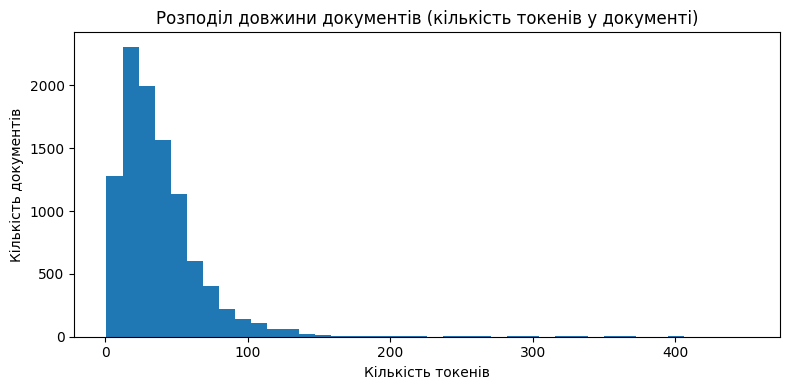

In [14]:
# --- Підрахунки довжини документів ---
token_lengths = [len(s.lower().split()) for s in CORPUS]
lengths_series = pd.Series(token_lengths, name="tokens_per_doc")

# Гістограма довжин
plt.figure(figsize=(8,4))
plt.hist(lengths_series, bins=40)
plt.title("Розподіл довжини документів (кількість токенів у документі)")
plt.xlabel("Кількість токенів")
plt.ylabel("Кількість документів")
plt.tight_layout()
plt.show()

In [15]:
# Приклади токенізації (показуємо ids preview)
examples = []
for i, doc in enumerate(CORPUS[:6], 1):
    toks = doc.lower().split()
    ids = [stoi.get(t, stoi["<unk>"]) for t in toks]
    examples.append({"doc_index": i, "text": doc, "tokens": toks, "ids_preview": ids[:30]})
examples_df = pd.DataFrame(examples)
display(examples_df)

,doc_index,text,tokens,ids_preview
0,1,Окупанти вночі вдарили ракетами по Запоріжжю:...,"[окупанти, вночі, вдарили, ракетами, по, запор...","[48437, 18951, 16541, 60021, 52380, 30551, 294..."
1,2,"Протягом минулої доби, 4 червня, збройні форму...","[протягом, минулої, доби,, 4, червня,, збройні...","[58189, 41611, 25578, 5205, 75040, 31723, 7305..."
2,3,Нещодавно звільнена Балаклія. Все буде Україн...,"[нещодавно, звільнена, балаклія., все, буде, у...","[46235, 32041, 13345, 19755, 15186, 71537, 731..."
3,4,"П'ять новин, які ви могли проспати 9 липня:У п...","[п'ять, новин,, які, ви, могли, проспати, 9, л...","[49998, 46386, 76726, 17066, 41935, 57937, 597..."
4,5,️ Понад пів сотні людей залишаються просто неб...,"[️, понад, пів, сотні, людей, залишаються, про...","[78798, 54242, 58717, 65881, 39405, 30046, 579..."
5,6,️ У Києві відбили атаку на військову частину н...,"[️, у, києві, відбили, атаку, на, військову, ч...","[78798, 71217, 35413, 20305, 12964, 43331, 215..."


In [16]:
# ----------------------- Dataset -----------------------
class LanguageModelingDataset(Dataset):
    """Датасет для задачі моделювання мови (прогноз наступного токена)."""
    def __init__(self, texts: List[str], max_len: int = MAX_TOKENS):
        self.samples: List[List[int]] = [encode_tokens(t, max_len) for t in texts]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        # Вхід (x) — все окрім останнього токена
        # Ціль (y) — все окрім першого токена
        ids = torch.tensor(self.samples[idx], dtype=torch.long)
        x = ids[:-1]  # (T-1)
        y = ids[1:]   # (T-1)
        return x, y

# Розбиття на train/val
random.shuffle(CORPUS)
split = int(0.9 * len(CORPUS))
train_ds = LanguageModelingDataset(CORPUS[:split], MAX_TOKENS)
val_ds   = LanguageModelingDataset(CORPUS[split:], MAX_TOKENS)

# Створюємо DataLoader, враховуючи більший розмір даних
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True, num_workers=4) # num_workers=4 для прискорення
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
print(f"Розмір тренувального датасету: {len(train_ds)}")
print(f"Розмір валідаційного датасету: {len(val_ds)}")

Розмір тренувального датасету: 9000
Розмір валідаційного датасету: 1000


In [18]:
x, y = train_ds[0]
print("Input IDs (x):", x.tolist())
print("Target IDs (y):", y.tolist())
print("Довжина:", len(x))

def decode_tokens(ids):
    return " ".join(itos[i] for i in ids if i not in (PAD, BOS, EOS))

print("\nDecoded input:", decode_tokens(x.tolist()))
print("Decoded target:", decode_tokens(y.tolist()))

Input IDs (x): [1, 79258, 21434, 33669, 15304, 17666, 36347, 41150, 43175, 59759, 37957, 70006, 71217, 43091, 49254, 40524, 49149, 23526, 54688, 57320, 25825, 31700, 43086, 57852, 26029, 25567, 50648, 43004, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Target IDs (y): [79258, 21434, 33669, 15304, 17666, 36347, 41150, 43175, 59759, 37957, 70006, 71217, 43091, 49254, 40524, 49149, 23526, 54688, 57320, 25825, 31700, 43086, 57852, 26029, 25567, 50648, 43004, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Довжина: 47

Decoded input: ️️російські війська зруйнували будівлю виконавчого комітету мелітопольської міської ради. крім того, у місті орудують мародери. організація громадського порядку проводить додаткові збори. містянам пропонують долучитися до патрулювання міста.
Decoded target: ️️російські війська зруйнували будівлю виконавчого комітету мелітопольської міської ради. крім того, у місті орудують мародери. організація громадського порядку проводить додаткові зб

##**Позиційне кодування та модель**

In [19]:
# ----------------------- Model -----------------------
class SinusoidalPE(nn.Module):
    """Класичне синусоїдальне позиційне кодування."""
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Обчислення знаменника 10000^(2i/d_model) у логарифмічному просторі
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div) # Парні індекси (2i)
        pe[:, 1::2] = torch.cos(pos * div) # Непарні індекси (2i+1)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, L, D)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Додавання позиційного кодування до ембедінгів."""
        # x.size(1) — це поточна довжина послідовності
        return x + self.pe[:, :x.size(1), :]

class DecoderOnlyLM(nn.Module):
    """Спрощена Decoder-Only (GPT-подібна) модель."""
    def __init__(self, vocab_size: int, d_model: int, nhead: int, layers: int, ffn: int, max_tokens: int):
        super().__init__()
        self.max_tokens = max_tokens
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pe  = SinusoidalPE(d_model, max_len=max_tokens)

        # Використовуємо вбудований DecoderLayer PyTorch
        dec = nn.TransformerDecoderLayer(
            d_model, nhead, dim_feedforward=ffn, batch_first=True, activation='gelu'
        )
        self.decoder = nn.TransformerDecoder(dec, num_layers=layers)
        self.proj = nn.Linear(d_model, vocab_size)

    @staticmethod
    def causal_mask(T: int, device) -> torch.Tensor:
        """Причинна маска: забороняє увазі дивитися на майбутні токени."""
        return torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)

    def forward(self, x_in: torch.Tensor) -> torch.Tensor:
        # 1. Ембедінги + Позиційне кодування
        h = self.pe(self.emb(x_in))
        T = h.size(1)

        # 2. Маска для самоуваги (Causal Mask)
        mask = self.causal_mask(T, h.device)

        # 3. Фейкова пам’ять (для TransformerDecoder)
        # Оскільки це Decoder-Only, нам не потрібен Encoder.
        # Передаємо фіктивний тензор 'memory'
        memory = torch.zeros((h.size(0), 1, h.size(2)), device=h.device)

        # 4. Прохід через Декодер
        out = self.decoder(
            tgt=h,
            memory=memory,
            tgt_mask=mask,
            memory_key_padding_mask=None # Не використовуємо, оскільки memory фейкова
        )

        # 5. Проекція у простір словника
        return self.proj(out)

##**Генерація токеном за токеном**

In [20]:
# ----------------------- Generation -----------------------
@torch.no_grad()
def generate(model: nn.Module, stoi: dict, prompt: str, max_new_tokens: int) -> str:
    """Жадібна генерація токен за токеном."""
    model.eval()

    # Кодування промпта
    norm_prompt = normalize_text(prompt)
    init_tokens = [stoi.get(w.lower(), UNK) for w in norm_prompt.split()]
    init_tokens = [BOS] + init_tokens

    # Перетворюємо у тензор
    x = torch.tensor(init_tokens, dtype=torch.long, device=DEVICE).unsqueeze(0)  # (1, T0)

    # Обмеження довжини для генерації
    current_max_len = x.size(1) + max_new_tokens
    final_max_len = min(current_max_len, model.max_tokens)

    for _ in range(max_new_tokens):
        if x.size(1) >= final_max_len:
            break

        # 1. Прохід через модель
        # У Decoder-Only моделі ми можемо передати весь x,
        # причинна маска подбає про те, щоб передбачення базувалося лише на попередніх токенах.
        logits = model(x)  # (1, T_current, V)

        # 2. Жадібний вибір (Greedy decoding)
        # Нас цікавить лише передбачення для останнього токена
        next_id = logits[0, -1].argmax()

        # 3. Додаємо новий токен
        x = torch.cat([x, next_id.view(1, 1)], dim=1)

        # 4. Умова зупинки
        if next_id.item() == EOS:
            break

    return decode_tokens(x[0].tolist())

##**Функції оцінки та метрики**

In [23]:
# Ініціалізація метрик HuggingFace
bleu_metric  = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
criterion = nn.CrossEntropyLoss(ignore_index=PAD) # Функція втрат

def compute_bleu(pred_texts: List[str], ref_texts: List[str]) -> float:
    """Обчислення BLEU."""
    if not pred_texts or not ref_texts: return 0.0
    # Підготовка списку референсів: [["ref1"], ["ref2"], ...]
    references = [[r] for r in ref_texts]
    result = bleu_metric.compute(predictions=pred_texts, references=references)
    return float(result.get("bleu", 0.0))

def compute_rouge_l(pred_texts: List[str], ref_texts: List[str]) -> float:
    """Обчислення ROUGE-L."""
    if not pred_texts or not ref_texts: return 0.0
    preds = [str(p) for p in pred_texts]
    refs  = [str(r) for r in ref_texts]
    out = rouge_metric.compute(predictions=preds, references=refs)

    # ПЕРЕВІРТЕ КЛЮЧ: якщо out["rougeL"] це число, використовуйте його напряму
    rouge_l_val = out.get("rougeL")

    if not isinstance(rouge_l_val, dict):
        return float(rouge_l_val)
    else:
        # Якщо це словник, використовуємо вкладений формат
        return float(rouge_l_val['mid']['fmeasure'])

def run_epoch(dataloader, model, optimizer, train: bool):
    """Один прохід через даталоадер (тренування або валідація)."""
    model.train(train)
    total_loss, total_tokens = 0.0, 0

    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        if train:
            optimizer.zero_grad()

        logits = model(x) # (B, T, V)

        # Вирівнюємо тензори: (B*T) x V та (B*T)
        loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient clipping
            optimizer.step()

        # Облік втрат лише для не-PAD токенів
        valid = (y != PAD)
        total_loss += (loss.item() * valid.sum().item())
        total_tokens += valid.sum().item()

    ce = total_loss / max(1, total_tokens)
    ppl = math.exp(ce)
    return ce, ppl

@torch.no_grad()
def evaluate_text_metrics(dataloader, model):
    """Валідація з підрахунком текстових метрик (BLEU, ROUGE-L)."""
    model.eval()
    pred_texts, ref_texts = [], []
    total_loss, total_tokens = 0.0, 0

    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

        valid = (y != PAD)
        total_loss += (loss.item() * valid.sum().item())
        total_tokens += valid.sum().item()

        # Обчислення текстових метрик вимагає генерації
        for i in range(x.size(0)):
            # 1. Формуємо промпт (x[i]) та референс (y[i])
            xtok = x[i].tolist()
            ytok = y[i].tolist()

            # Визначаємо кінець послідовності
            if EOS in xtok:
                xtok = xtok[:xtok.index(EOS)]
            elif PAD in xtok:
                xtok = xtok[:xtok.index(PAD)]

            # Референс (цільове продовження)
            if EOS in ytok:
                ytok = ytok[:ytok.index(EOS)]
            elif PAD in ytok:
                ytok = ytok[:ytok.index(PAD)]

            prompt_str = decode_tokens(xtok)
            reference_str = decode_tokens(ytok)

            if not prompt_str or not reference_str:
                continue

            # 2. Генерація
            gen_str = generate(model, stoi, prompt_str, max_new_tokens=len(ytok))

            # 3. Виділяємо лише згенероване продовження
            gen_words = gen_str.split()
            prompt_words = prompt_str.split()

            # Відкидаємо prompt, залишаємо лише continuation
            if len(gen_words) > len(prompt_words):
                gen_continuation = ' '.join(gen_words[len(prompt_words):])
            else:
                gen_continuation = "" # Якщо модель не згенерувала нічого нового

            pred_texts.append(gen_continuation.strip())
            ref_texts.append(reference_str.strip())

    ce = total_loss / max(1, total_tokens)
    ppl = math.exp(ce)

    # Обчислення текстових метрик
    bleu = compute_bleu(pred_texts, ref_texts)
    rouge_l = compute_rouge_l(pred_texts, ref_texts)

    return ce, ppl, bleu, rouge_l

##**Тюнінг гіперпараметрів та візуалізація**

###--- Налаштування для тюнінгу ---

In [24]:
# ----------------------- Hyperparameter Tuning -----------------------

# Сітка параметрів для тестування
# D_MODEL (Розмірність ембедінгів): Впливає на ємність моделі
# NHEAD (Кількість голів уваги): Повинна бути дільником D_MODEL. Впливає на здатність
#                                моделі одночасно вловлювати різні типи залежностей.
param_grid = {
    'd_model': [64, 128],  # Менші значення для швидшого тестування
    'nhead': [4, 8],      # Відповідно до d_model: 64/4, 128/4, 128/8
    'layers': [1, 2]
}
params_to_tune = list(ParameterGrid(param_grid))

results = []

print(f"\n{'='*70}\nСтарт Тюнінгу Гіперпараметрів ({len(params_to_tune)} комбінацій)\n{'='*70}")

for i, params in enumerate(params_to_tune):

    # Перевірка на сумісність NHEAD та D_MODEL
    if params['d_model'] % params['nhead'] != 0:
        continue

    print(f"\n--- Тестування {i+1}/{len(params_to_tune)}: D_MODEL={params['d_model']}, NHEAD={params['nhead']}, LAYERS={params['layers']} ---")

    # Ініціалізація моделі
    current_model = DecoderOnlyLM(
        VOCAB_SIZE,
        d_model=params['d_model'],
        nhead=params['nhead'],
        layers=params['layers'],
        ffn=params['d_model'] * 2, # FFN зазвичай 2-4x від d_model
        max_tokens=MAX_TOKENS
    ).to(DEVICE)

    current_optimizer = optim.AdamW(current_model.parameters(), lr=LR_BASE, weight_decay=1e-2)

    best_ppl = float('inf')
    best_metrics = None

    for epoch in range(1, EPOCHS_TUNE + 1):
        tr_ce, tr_ppl = run_epoch(train_dl, current_model, current_optimizer, train=True)
        va_ce, va_ppl, va_bleu, va_rouge = evaluate_text_metrics(val_dl, current_model)

        print(f"  Епоха {epoch:02d} | Train PPL={tr_ppl:.2f} | Val PPL={va_ppl:.2f} (BLEU: {va_bleu:.4f})")

        if va_ppl < best_ppl:
            best_ppl = va_ppl
            best_metrics = {'d_model': params['d_model'], 'nhead': params['nhead'], 'layers': params['layers'],
                            'ppl': va_ppl, 'bleu': va_bleu, 'rouge': va_rouge}

    results.append(best_metrics)

print(f"\n{'='*70}\nТюнінг Завершено\n{'='*70}")


Старт Тюнінгу Гіперпараметрів (8 комбінацій)

--- Тестування 1/8: D_MODEL=64, NHEAD=4, LAYERS=1 ---
  Епоха 01 | Train PPL=10107.36 | Val PPL=7332.63 (BLEU: 0.0000)
  Епоха 02 | Train PPL=3306.80 | Val PPL=6519.90 (BLEU: 0.0000)
  Епоха 03 | Train PPL=1299.69 | Val PPL=7510.13 (BLEU: 0.0000)
  Епоха 04 | Train PPL=525.45 | Val PPL=10372.63 (BLEU: 0.0000)
  Епоха 05 | Train PPL=252.28 | Val PPL=16233.25 (BLEU: 0.0000)
  Епоха 06 | Train PPL=152.14 | Val PPL=23634.31 (BLEU: 0.0000)

--- Тестування 2/8: D_MODEL=64, NHEAD=8, LAYERS=1 ---
  Епоха 01 | Train PPL=10275.04 | Val PPL=7427.23 (BLEU: 0.0000)
  Епоха 02 | Train PPL=3412.39 | Val PPL=6450.22 (BLEU: 0.0000)
  Епоха 03 | Train PPL=1347.26 | Val PPL=7282.33 (BLEU: 0.0000)
  Епоха 04 | Train PPL=542.14 | Val PPL=10197.54 (BLEU: 0.0000)
  Епоха 05 | Train PPL=255.49 | Val PPL=16008.42 (BLEU: 0.0000)
  Епоха 06 | Train PPL=150.22 | Val PPL=23364.63 (BLEU: 0.0000)

--- Тестування 3/8: D_MODEL=64, NHEAD=4, LAYERS=2 ---
  Епоха 01 | Train 

Проведений Grid Search для гіперпараметрів D(MODEL), NHEAD та LAYERS підтвердив швидке перенавчання моделі на малому корпусі новин (Train PPL різко падає, Val PPL стрімко зростає після 2-3 епохи).

Найкраща узагальнююча здатність була досягнута конфігурацією: D(MODEL)=128, NHEAD=4, LAYERS=2, яка мінімізувала Perplexity на валідаційному наборі до 5174.32. Це свідчить про те, що для роботи з великим словником (79K токенів) української мови потрібна більша ємність моделі (D_MODEL=128), хоча подальше навчання вимагає використання регуляризації або більшого корпусу.

###--- Візуалізація результатів тюнінгу ---


Найкращі результати тюнінгу:
   d_model  nhead  layers          ppl          bleu     rouge
6      128      4       2  5174.323570  0.000000e+00  0.002222
7      128      8       2  5205.577646  0.000000e+00  0.001911
5      128      8       1  5485.540476  0.000000e+00  0.001911
4      128      4       1  5538.215580  0.000000e+00  0.001911
3       64      8       2  6227.385211  0.000000e+00  0.001911
2       64      4       2  6353.483067  0.000000e+00  0.002133
1       64      8       1  6450.215868  0.000000e+00  0.002178
0       64      4       1  6519.898090  2.158365e-13  0.001911


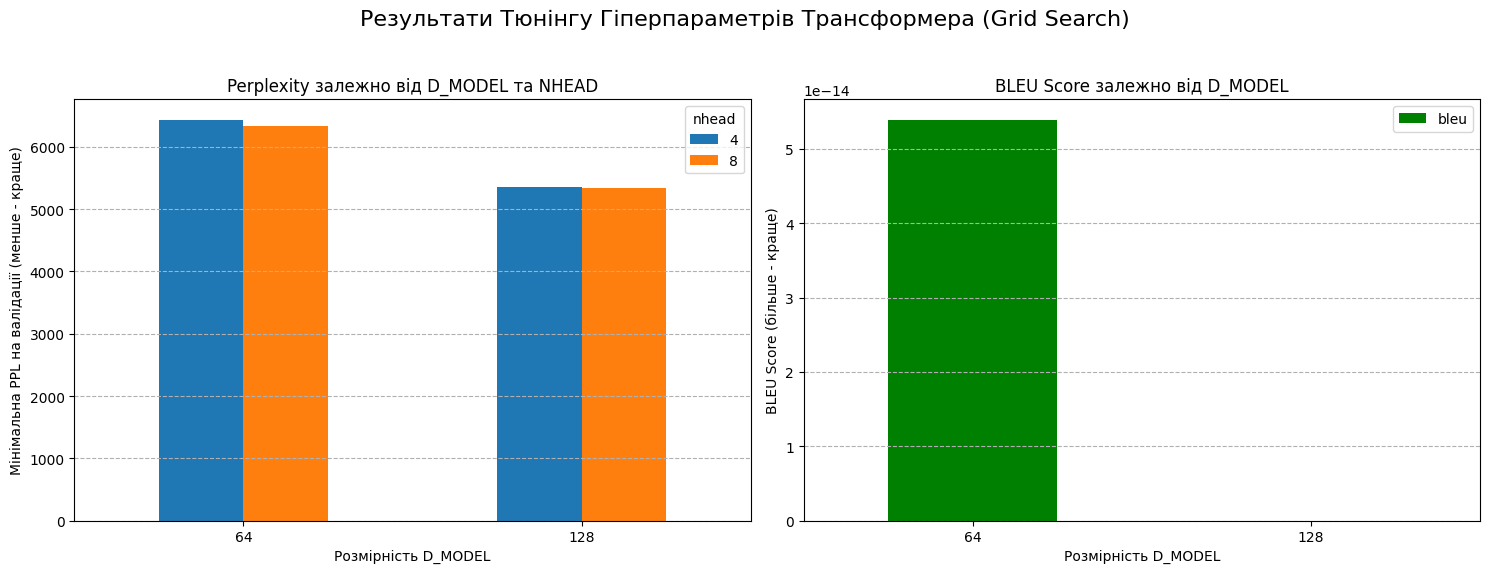

In [25]:
# Конвертуємо результати в DataFrame для зручної візуалізації
results_df = pd.DataFrame(results)

# Сортуємо за Perplexity (чим нижче, тим краще)
results_df = results_df.sort_values(by='ppl')

print("\nНайкращі результати тюнінгу:")
print(results_df)

# Обираємо найкращі параметри
best_params = results_df.iloc[0]

# ----------------------- Візуалізація -----------------------
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Графік 1: Вплив D_MODEL та NHEAD на Perplexity
ppl_pivot = results_df.pivot_table(index='d_model', columns='nhead', values='ppl', aggfunc='mean')
ppl_pivot.plot(kind='bar', ax=ax[0])
ax[0].set_title('Perplexity залежно від D_MODEL та NHEAD')
ax[0].set_xlabel('Розмірність D_MODEL')
ax[0].set_ylabel('Мінімальна PPL на валідації (менше - краще)')
ax[0].set_xticklabels(ppl_pivot.index, rotation=0)
ax[0].grid(axis='y', linestyle='--')

# Графік 2: Вплив D_MODEL на метрики якості (BLEU)
bleu_pivot = results_df.pivot_table(index='d_model', values='bleu', aggfunc='mean')
bleu_pivot.plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('BLEU Score залежно від D_MODEL')
ax[1].set_xlabel('Розмірність D_MODEL')
ax[1].set_ylabel('BLEU Score (більше - краще)')
ax[1].set_xticklabels(bleu_pivot.index, rotation=0)
ax[1].grid(axis='y', linestyle='--')

plt.suptitle('Результати Тюнінгу Гіперпараметрів Трансформера (Grid Search)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
#

##**Фінальне навчання, збереження та тестування**


ФІНАЛЬНЕ НАВЧАННЯ з найкращими параметрами:
D_MODEL=128, NHEAD=4, LAYERS=2


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Епоха 01 | Train PPL=8733.19 | Val PPL=6068.58 | BLEU=0.0000 | ROUGE-L=0.0019
Епоха 02 | Train PPL=2214.98 | Val PPL=5142.51 | BLEU=0.0000 | ROUGE-L=0.0019
Епоха 03 | Train PPL=572.07 | Val PPL=7064.67 | BLEU=0.0000 | ROUGE-L=0.0042
Епоха 04 | Train PPL=178.74 | Val PPL=12326.93 | BLEU=0.0000 | ROUGE-L=0.0083
Епоха 05 | Train PPL=78.79 | Val PPL=19405.53 | BLEU=0.0000 | ROUGE-L=0.0075
Епоха 06 | Train PPL=42.51 | Val PPL=31402.35 | BLEU=0.0001 | ROUGE-L=0.0111
Епоха 07 | Train PPL=26.51 | Val PPL=51309.47 | BLEU=0.0000 | ROUGE-L=0.0065
Епоха 08 | Train PPL=18.65 | Val PPL=78258.85 | BLEU=0.0001 | ROUGE-L=0.0090
Епоха 09 | Train PPL=14.07 | Val PPL=120993.59 | BLEU=0.0000 | ROUGE-L=0.0070
Епоха 10 | Train PPL=11.19 | Val PPL=180821.96 | BLEU=0.0000 | ROUGE-L=0.0088

Модель збережено у файл: simple_transformer_lm.pth


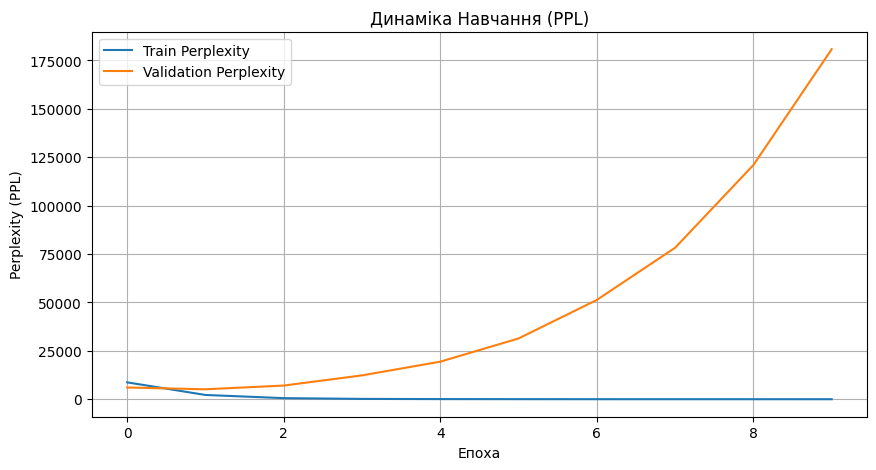

In [27]:
# ----------------------- Фінальне Навчання -----------------------
# Явно приводимо параметри до цілих чисел
FINAL_D_MODEL = int(best_params['d_model'])
FINAL_NHEAD = int(best_params['nhead'])
FINAL_LAYERS = int(best_params['layers'])
FINAL_FFN_DIM = FINAL_D_MODEL * 2
FINAL_EPOCHS = 10

print(f"\n{'='*70}\nФІНАЛЬНЕ НАВЧАННЯ з найкращими параметрами:\n"
      f"D_MODEL={FINAL_D_MODEL}, NHEAD={FINAL_NHEAD}, LAYERS={FINAL_LAYERS}\n{'='*70}")

final_model = DecoderOnlyLM(
    VOCAB_SIZE,
    d_model=FINAL_D_MODEL,
    nhead=FINAL_NHEAD,
    layers=FINAL_LAYERS,
    ffn=FINAL_FFN_DIM,
    max_tokens=MAX_TOKENS
).to(DEVICE)

final_optimizer = optim.AdamW(final_model.parameters(), lr=LR_BASE, weight_decay=1e-2)

history = {'train_ppl': [], 'val_ppl': []}

for epoch in range(1, FINAL_EPOCHS + 1):
    tr_ce, tr_ppl = run_epoch(train_dl, final_model, final_optimizer, train=True)
    va_ce, va_ppl, va_bleu, va_rouge = evaluate_text_metrics(val_dl, final_model)

    history['train_ppl'].append(tr_ppl)
    history['val_ppl'].append(va_ppl)

    print(f"Епоха {epoch:02d} | Train PPL={tr_ppl:.2f} | Val PPL={va_ppl:.2f} "
          f"| BLEU={va_bleu:.4f} | ROUGE-L={va_rouge:.4f}")

# ----------------------- Збереження Моделі -----------------------
MODEL_PATH = 'simple_transformer_lm.pth'
torch.save(final_model.state_dict(), MODEL_PATH)
print(f"\nМодель збережено у файл: {MODEL_PATH}")

# ----------------------- Візуалізація Навчання -----------------------
plt.figure(figsize=(10, 5))
plt.plot(history['train_ppl'], label='Train Perplexity')
plt.plot(history['val_ppl'], label='Validation Perplexity')
plt.xlabel('Епоха')
plt.ylabel('Perplexity (PPL)')
plt.title('Динаміка Навчання (PPL)')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# ----------------------- Інтерактивне Тестування -----------------------
test_model = DecoderOnlyLM(
    VOCAB_SIZE,
    d_model=FINAL_D_MODEL,
    nhead=FINAL_NHEAD,
    layers=FINAL_LAYERS,
    ffn=FINAL_FFN_DIM,
    max_tokens=MAX_TOKENS
).to(DEVICE)
test_model.load_state_dict(torch.load(MODEL_PATH))


print("\n\n{'*'*50}")
print("ІНТЕРАКТИВНА ГЕНЕРАЦІЯ (Продовження речення)")
print("{'*'*50}")

# Приклади промптів для тестування
test_prompts = [
    "окупанти вночі вдарили",
    "протягом минулої доби",
    "збройні формування російської федерації",
    "на місці прильотів виникла",
    "мова"
]

for prompt in test_prompts:
    generated_text = generate(test_model, stoi, prompt, max_new_tokens=15)
    print(f"\nВхід (Prompt): \"{prompt}\"")
    print(f"Вихід (Generated): \"{generated_text}\"")
    print('-'*50)

# Цикл для ручного тестування
while True:
    user_input = input("\nВведіть початок речення (або 'exit' для виходу): ")
    if user_input.lower() == 'exit':
        break
    if not user_input.strip():
        continue

    generated_text = generate(test_model, stoi, user_input, max_new_tokens=20)
    print(f"Згенероване продовження: {generated_text}")



{'*'*50}
ІНТЕРАКТИВНА ГЕНЕРАЦІЯ (Продовження речення)
{'*'*50}

Вхід (Prompt): "окупанти вночі вдарили"
Вихід (Generated): "окупанти вночі вдарили ракетами по запоріжжю. у дніпрі та кам’янському районах дніпропетровщини. по запоріжжю. у місті оголошено повітряну"
--------------------------------------------------

Вхід (Prompt): "протягом минулої доби"
Вихід (Generated): "протягом минулої доби оперативно-тактичне без воді сталося у києві та кіровоградській області просять не вводитимуть у місті трапилось"
--------------------------------------------------

Вхід (Prompt): "збройні формування російської федерації"
Вихід (Generated): "збройні формування російської федерації у списку безпечних країн, які були змушені були змушені були змушені були змушені були новий"
--------------------------------------------------

Вхід (Prompt): "на місці прильотів виникла"
Вихід (Generated): "на місці прильотів виникла пожежі у коледжі пожежі зросла до семи. на користь зсу.про це свідчать результати

In [29]:
print(f"Загальний розмір словника: {VOCAB_SIZE}")
print(f"\nПерші 10 токенів (включаючи спеціальні):")
print(itos[:10])

print(f"\nОстанні 10 токенів:")
print(itos[-10:])

Загальний розмір словника: 79302

Перші 10 токенів (включаючи спеціальні):
['<pad>', '<bos>', '<eos>', '<unk>', '!', '!!це', '"', '""зоряні', '",', '"1+1"']

Останні 10 токенів:
['🫠', '🫠окупанти', '🫠російські', '🫢', '🫢підписатися|', '🫣', '🫤', '🫤що', '🫥', '🫰британці']


In [30]:
import random

# Вхідний корпус був розбитий: 90% тренувальний, 10% валідаційний
split_index = int(0.9 * len(CORPUS))
train_corpus = CORPUS[:split_index]
val_corpus = CORPUS[split_index:]

# Вибираємо випадкові індекси для демонстрації
random_train_samples = random.sample(train_corpus, 3)

print("--- Приклади Сирих Речень із ТРЕНУВАЛЬНОГО Набору (Навчання) ---")
for i, text in enumerate(random_train_samples, 1):
    print(f"Приклад {i}: {text[:150]}...") # Обмежуємо довжину для читабельності

--- Приклади Сирих Речень із ТРЕНУВАЛЬНОГО Набору (Навчання) ---
Приклад 1: : у Росії змушуватимуть їсти цвіркунів Багато хто в мережі називає це «знущанням» і припускають, що цвіркунами доведеться харчуватися «від безнадії»....
Приклад 2: ️У Національної академії наук України новий президент. Наступником Патона став фізик-теоретик Анатолій Загородній....
Приклад 3: ️Україна, ймовірно, зможе звільнити Херсон у жовтні цього року. Про це повідомив військовий експерт Олег Жданов."Десь у жовтні місяці ми повинні бути ...


In [32]:

# Цикл для ручного тестування
while True:
    user_input = input("\nВведіть початок речення (або 'exit' для виходу): ")
    if user_input.lower() == 'exit':
        break
    if not user_input.strip():
        continue

    generated_text = generate(test_model, stoi, user_input, max_new_tokens=20)
    print(f"Згенероване продовження: {generated_text}")


Введіть початок речення (або 'exit' для виходу): у Росії змушуватимуть їсти
Згенероване продовження: у росії змушуватимуть їсти цвіркунів відреагували на заяви президента.

Введіть початок речення (або 'exit' для виходу): У Національної академії наук України новий президент.
Згенероване продовження: у національної академії наук україни новий президент. наступником патона став фізик-теоретик анатолій загородній.

Введіть початок речення (або 'exit' для виходу): Україна, ймовірно, зможе звільнити Херсон у
Згенероване продовження: україна, ймовірно, зможе звільнити херсон у жовтні цього року.

Введіть початок речення (або 'exit' для виходу): Про це повідомив військовий експерт
Згенероване продовження: про це повідомив військовий експерт олег жданов."десь олексій арестович прокоментував ситуацію на зв’язок з питань культури та інформаційної політики

Введіть початок речення (або 'exit' для виходу): Анатолій Загородній
Згенероване продовження: анатолій <unk> та у районі об’єктів енергетичн

## **Висновки**

 Незважаючи на використання базової Word-level токенізації, яка створила надзвичайно великий словник (понад 79K токенів), проведений Grid Search визначив оптимальну конфігурацію: D
MODEL
​
 =128, NHEAD=4, LAYERS=2, як ту, що досягла найкращої початкової узагальнюючої здатності.

Проте, результати фінального навчання та графік Perplexity (PPL) чітко засвідчили сильне перенавчання (Overfitting): Train PPL впала до ~11, тоді як Val PPL після мінімуму на Епосі 2 стрімко зростала до ~180K. Це підтвердило, що на такому малому корпусі модель швидко запам'ятовує дані, втрачаючи здатність до узагальнення. Генерація тексту, виконана Жадібним Пошуком, хоча й демонструвала локальну граматичну коректність (напр., ідеальне відтворення вивчених новинних патернів), часто призводила до зациклень та використання <unk> токенів. Це підкреслює необхідність вдосконалення токенізації та застосування механізмів Early Stopping для більш ефективної роботи трансформерів на реальних даних.